# Process Data Table

This notebook takes output from the simulator and processes it into the format suggested by the flexsurv R package for fitting a multi-state survival model.

Start by Pulling in relevant libraries.


In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import scipy.stats as st
import scipy.optimize as op
from scipy import integrate
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime, date 
from datetime import timedelta
from tqdm.notebook import tqdm

In [2]:
df = pd.read_csv('./data_files/Simulated_COVID.csv')
df = df.drop(['Unnamed: 0'], axis = 1)
dtpull = datetime.fromisoformat('2020-05-31 00:00:02')

In [3]:
# Convert string dates to datetimes

ld=len(df)
dob_vec=df['DateOfBirth'].values

for i in range(0,ld):
    dob = df.DateOfBirth.values[i]
    adt = df.HospitalAdmissionTime.values[i]
    at = df.StartTimeCriticalCare.values[i]
    dt = df.DischargeTimeCriticalCare.values[i]
    mt = df.DateOfDeath.values[i]
    hdt = df.HospitalDischargeTime.values[i]
    if (not pd.isna(at)):
        df.StartTimeCriticalCare.iloc[i] =  datetime.fromisoformat(at)
    if (not pd.isna(dt)):
        df.DischargeTimeCriticalCare.iloc[i] = datetime.fromisoformat(dt)
    if (not pd.isna(mt)):
        df.DateOfDeath.iloc[i] = datetime.fromisoformat(mt)
    if (not pd.isna(hdt)):
        df.HospitalDischargeTime.iloc[i] = datetime.fromisoformat(hdt)  
    df.HospitalAdmissionTime.iloc[i] = datetime.fromisoformat(adt) 
    df.DateOfBirth.iloc[i] = datetime.fromisoformat(dob)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [4]:
Q = [              # Matrix of allowed transitions
    [0,1,0,1,1],
    [0,0,1,0,1],
    [0,1,0,1,0],
    [0,0,0,0,0],
    [0,0,0,0,0]
] 

In [5]:
# Create a data frame - each row corresponds to a transition made by an individual along with time of transition since admission
# and covariate values.

new_df = pd.DataFrame()
ids = df['NHSNumber'].unique()

for l, i in tqdm(enumerate(ids)):
    
    # Extracting relevant times for an individual
    if (np.isnan(i)):
        print('Caught null error at step; ' + str(l)+ 'NHS Number =' +str(i)) # Remove null NHS numbers
        continue
    NHS_df = df.loc[df['NHSNumber'] == i]
    if(len(NHS_df)>1):
        NHS_df = NHS_df.dropna(axis = 0, subset = ["StartTimeCriticalCare"])
        
    HospitalStay = NHS_df.HospitalAdmissionTime.values[0] 
    adt = NHS_df.HospitalAdmissionTime.values[0] 
    ICU_admit = NHS_df.StartTimeCriticalCare.values
    ICU_discharge = NHS_df.DischargeTimeCriticalCare.values[-1]
    NHS_discharge = NHS_df.HospitalDischargeTime.values[-1]
    dob = NHS_df.DateOfBirth.values[0]  
    NHS_death = NHS_df.DateOfDeath.values[-1]
    States = np.ones(1) 
    ARS = NHS_df.ARSDays.values
    BRS = NHS_df.BRSDays.values
    cum_ARS = np.zeros(1)
    cum_BRS = np.zeros(1)
     
     
    # Logical indicator for death in hospital ward and not an ICU    
    if (pd.isna(ICU_admit[0])): 
        if (not pd.isna(NHS_discharge)):
            Hosp_death = ((not pd.isna(NHS_death)) and NHS_death<=NHS_discharge)
        else:
            Hosp_death = (not pd.isna(NHS_death))
        
    elif (not pd.isna(ICU_discharge)):
        if (not pd.isna(NHS_discharge)):
            Hosp_death = ((not pd.isna(NHS_death)) and NHS_death<=NHS_discharge 
                      and ICU_discharge<NHS_discharge) or (ICU_discharge<NHS_discharge)
        else:
            Hosp_death = (not pd.isna(NHS_death))
    else:
        Hosp_death = False
    # Logical indicator for death in an ICU
    if (not pd.isna(ICU_discharge) and not pd.isna(NHS_death)):
        ICU_death = (not pd.isna(ICU_admit[0]) and not Hosp_death and not (pd.isna(NHS_death) and NHS_death <=ICU_discharge))
    else:
        ICU_death = False 
            
        
    
    # Create new row for each transition, with corresponding state
    if (not pd.isna(ICU_admit[0])): # Do you have an ICU stay?
        
            CriticalCare = NHS_df[['StartTimeCriticalCare','DischargeTimeCriticalCare']].values
            CriticalCare = CriticalCare[~pd.isna(CriticalCare)]
            
            n_rows=np.size(CriticalCare) # Each element should have its own row
            CriticalCare=np.resize(CriticalCare, (n_rows, 1))
            CC_states = np.zeros(len(CriticalCare))
            
            
            
            for k in range(0, n_rows): # States alternate between 2 and 3 if multiple ICU visits exist
                if (k%2 == 0):
                    CC_states[k] = 2
                    cum_BRS = np.append(cum_BRS, cum_BRS[-1])
                    cum_ARS = np.append(cum_ARS, cum_ARS[-1])
                    
                else:
                    CC_states[k] = 3
                    cum_BRS = np.append(cum_BRS, cum_BRS[-1] + BRS[int((k-1)/2)])
                    cum_ARS = np.append(cum_ARS, cum_ARS[-1] + ARS[int((k-1)/2)])
                    
                    
            # Has a person died in the ICU?        
            if((not pd.isna(NHS_death))):
                if(pd.isna(ICU_discharge)):
                    CC_states[-1] = 5
                elif(NHS_death<=ICU_discharge):
                    CC_states[-1] = 5
            
            # Deal with case where individuals are admitted straight to ICU    
            if (ICU_admit[0] == adt): 
                HospitalStay = CriticalCare
                States = CC_states.T
                cum_ARS = cum_ARS[1:]
                cum_BRS = cum_BRS[1:]
            else:
                HospitalStay = np.append(HospitalStay, CriticalCare) # Append hospital admission and ICU times
                States = np.append(States, CC_states) 
    
    # End state, 5 corresponds to death, 4 to discharge
    if ((Hosp_death and (not pd.isna(NHS_death) ) ) ): 
        States = np.append(States, 5)
    elif (not ((not pd.isna(NHS_death)) and (pd.isna(ICU_discharge) or NHS_death<=ICU_discharge or pd.isna(ICU_admit[0]))) 
          and (not pd.isna(NHS_discharge)) or (NHS_death>NHS_discharge)):
        States = np.append(States, 4)
        
    if (pd.isna(ICU_admit[0])):
        cum_ARS = np.append(cum_ARS, 0)
        cum_BRS = np.append(cum_BRS, 0)
    elif (not pd.isna(ICU_discharge) and not ICU_death and not pd.isna(NHS_discharge)):
        cum_ARS = np.append(cum_ARS, cum_ARS[-1])
        cum_BRS = np.append(cum_BRS, cum_BRS[-1])
    
    # Check this is a discharge (not transfer/death)
    if((not pd.isna(NHS_discharge)) and (NHS_discharge !=ICU_discharge) ): 
        HospitalStay = np.append(HospitalStay, NHS_discharge)
    
    # Reshape into desired format for data frame
    if (isinstance(HospitalStay, date)):
        HospitalStay = np.array([HospitalStay])
    else:
        HospitalStay = np.resize(HospitalStay, (len(HospitalStay),1))
    
     
    # Creates a covariate that is set to 1 after a patient is discharged from ICU
    num_events = len(HospitalStay)
    ICU_covariate = np.ones(num_events) 
    if (ICU_admit[0]==adt):
        ICU_covariate[0] = 0
    else:
        ICU_covariate[0:np.minimum(num_events,2)] = 0
        
    # Categorising individuals into age groups
    age = np.floor((adt - dob).days/365)
    if (age < 26):
        age = 0
    elif(age <65 and age>25):
        age = 0
    elif(age<81 and age>64):
        age = 1
    elif(age>80):
        age = 2
        
    sex = np.ones(1)
    if (np.asarray(NHS_df.Sex)[0] == 'Female'):
        sex = 0
    elif (np.asarray(NHS_df.Sex)[0] == 'Not Known' or np.asarray(NHS_df.Sex)[0] == 'Not Specified' 
          or np.asarray(NHS_df.Sex)[0] == 'Unassigned' or np.asarray(NHS_df.Sex)[0] == 'Unknown'):
        sex = 2

    ages = np.repeat(age, num_events)
    adt = np.repeat(adt, num_events)
    sex = np.repeat(sex, num_events)
   
    
    timepull = (dtpull - HospitalStay.flatten()[-1]).total_seconds()/(60*60*24)    
    # Create the full data frame for an individual
    try: # Catches errors for individuals discharged directly from ICU (assumed to be transfers)
        for k in range(0, num_events):
            HospitalStay[k] = ((HospitalStay[k] - adt)[0].total_seconds())/(60*60*24)
        if (num_events==1):
            HospitalStay = np.append(HospitalStay, [ages[0], ICU_covariate[0], States[0], sex[0], cum_ARS[0], cum_BRS[0]])
            HospitalStay = pd.DataFrame(HospitalStay).T
        else:
            HospitalStay = np.concatenate([HospitalStay, np.atleast_2d(ages).T, np.atleast_2d(ICU_covariate).T, 
                                           np.atleast_2d(States).T, np.atleast_2d(sex).T, np.atleast_2d(cum_ARS).T, 
                                           np.atleast_2d(cum_BRS).T], axis = 1)
            HospitalStay = pd.DataFrame(HospitalStay)

        # Creates number of censoring rows based on possible transitions from each state
        k=0
        ndups = []
        Qbase = Q.copy()
        for c in range(0,len(Q)):
            ndups.append(0)
            for j in range(0,len(Q[c])):
                if Q[c][j] == 1:
                    k += 1
                    Qbase[c][j] = k
                    ndups[c] +=1
                    
        duplicated_df_vals = []  

        for b in range(0,len(HospitalStay)):  
            row = HospitalStay.iloc[b,:].values
            ii = int(HospitalStay.iloc[b,3])
            nreps = ndups[ii-1]
            if (b<(len(HospitalStay)-1)): # Not an end
                jj = int(HospitalStay.iloc[b+1,3])
                for qi, qval in enumerate(Qbase[ii-1]):
                    if (qval>0):
                        if (qi==(jj-1)):
                            newrow = np.append(row,[HospitalStay.iloc[b+1,0] -
                                                    HospitalStay.iloc[b,0],ii,jj,1,qval]) # Observed transition
                        else:
                            newrow =  np.append(row,[HospitalStay.iloc[b+1,0] -
                                                     HospitalStay.iloc[b,0],ii,qi+1,0,qval]) # Possible transitions (not observed)
                        duplicated_df_vals.append(newrow)
            else:
                for qi, qval in enumerate(Qbase[ii-1]):
                    if (qval>0):
                        newrow =  np.append(row,[timepull,ii,qi+1,0,qval]) # Possible transitions (censored)
                        duplicated_df_vals.append(newrow)                    

        HospitalStayForFS = pd.DataFrame(duplicated_df_vals)

        NHS_nos = pd.DataFrame(np.repeat(i, len(HospitalStayForFS)))
        df_individual = pd.concat([NHS_nos, HospitalStayForFS], axis = 1)

        new_df = new_df.append(df_individual)
    except:
        print('Caught append error at step ' + str(l) + ' NHS Number =' +str(i))
        continue
new_df.columns = ["NHSNumber", "Time", "Age","ICU_cov", "State", "Sex", "ARS", "BRS", "TimeInState", "From", "To", "Censored", "TransitionNumber"]

In [6]:
new_df.to_csv('./data_files/Current_COVID.csv')

In [7]:
nboot = 400 # Number of bootstrap samples - this is the start of Monte Carlo methods so seed for reproducibility
np.random.seed(17)
bidsmat = np.zeros((nboot,len(ids)))
for b in range(0,nboot):
    bidsmat[b,:] = np.random.choice(ids,size=len(ids))

In [8]:
for bb in tqdm(range(0,nboot)):
    
    bids = bidsmat[bb,:]  
    new_df = pd.DataFrame()
    
    for l, i in enumerate(bids):

        # Extracting relevant times for an individual
        if (np.isnan(i)):
            print('Caught null error at step ' + str(l)+ 'NHS Number =' +str(i)) # Remove null NHS numbers
            continue
        NHS_df = df.loc[df['NHSNumber'] == i]
        if(len(NHS_df)>1):
            NHS_df = NHS_df.dropna(axis = 0, subset = ["StartTimeCriticalCare"])

        HospitalStay = NHS_df.HospitalAdmissionTime.values[0] 
        adt = NHS_df.HospitalAdmissionTime.values[0] 
        ICU_admit = NHS_df.StartTimeCriticalCare.values
        ICU_discharge = NHS_df.DischargeTimeCriticalCare.values[-1]
        NHS_discharge = NHS_df.HospitalDischargeTime.values[-1]
        dob = NHS_df.DateOfBirth.values[0]  
        NHS_death = NHS_df.DateOfDeath.values[-1]
        States = np.ones(1) 
        ARS = NHS_df.ARSDays.values
        BRS = NHS_df.BRSDays.values
        cum_ARS = np.zeros(1)
        cum_BRS = np.zeros(1)


        # Logical indicator for death in hospital ward and not an ICU    
        if (pd.isna(ICU_admit[0])): 
            if (not pd.isna(NHS_discharge)):
                Hosp_death = ((not pd.isna(NHS_death)) and NHS_death<=NHS_discharge)
            else:
                Hosp_death = (not pd.isna(NHS_death))

        elif (not pd.isna(ICU_discharge)):
            if (not pd.isna(NHS_discharge)):
                Hosp_death = ((not pd.isna(NHS_death)) and NHS_death<=NHS_discharge 
                          and ICU_discharge<NHS_discharge) or (ICU_discharge<NHS_discharge)
            else:
                Hosp_death = (not pd.isna(NHS_death))
        else:
            Hosp_death = False
        # Logical indicator for death in an ICU
        if (not pd.isna(ICU_discharge) and not pd.isna(NHS_death)):
            ICU_death = (not pd.isna(ICU_admit[0]) and not Hosp_death and not (pd.isna(NHS_death) and NHS_death <=ICU_discharge))
        else:
            ICU_death = False 



        # Create new row for each transition, with corresponding state
        if (not pd.isna(ICU_admit[0])): # Do you have an ICU stay?

                CriticalCare = NHS_df[['StartTimeCriticalCare','DischargeTimeCriticalCare']].values
                CriticalCare = CriticalCare[~pd.isna(CriticalCare)]

                n_rows=np.size(CriticalCare) # Each element should have its own row
                CriticalCare=np.resize(CriticalCare, (n_rows, 1))
                CC_states = np.zeros(len(CriticalCare))



                for k in range(0, n_rows): # States alternate between 2 and 3 if multiple ICU visits exist
                    if (k%2 == 0):
                        CC_states[k] = 2
                        cum_BRS = np.append(cum_BRS, cum_BRS[-1])
                        cum_ARS = np.append(cum_ARS, cum_ARS[-1])

                    else:
                        CC_states[k] = 3
                        cum_BRS = np.append(cum_BRS, cum_BRS[-1] + BRS[int((k-1)/2)])
                        cum_ARS = np.append(cum_ARS, cum_ARS[-1] + ARS[int((k-1)/2)])


                # Has a person died in the ICU?        
                if((not pd.isna(NHS_death))):
                    if(pd.isna(ICU_discharge)):
                        CC_states[-1] = 5
                    elif(NHS_death<=ICU_discharge):
                        CC_states[-1] = 5

                # Deal with case where individuals are admitted straight to ICU    
                if (ICU_admit[0] == adt): 
                    HospitalStay = CriticalCare
                    States = CC_states.T
                    cum_ARS = cum_ARS[1:]
                    cum_BRS = cum_BRS[1:]
                else:
                    HospitalStay = np.append(HospitalStay, CriticalCare) # Append hospital admission and ICU times
                    States = np.append(States, CC_states) 

        # End state, 5 corresponds to death, 4 to discharge
        if ((Hosp_death and (not pd.isna(NHS_death) ) ) ): 
            States = np.append(States, 5)
        elif (not ((not pd.isna(NHS_death)) and (pd.isna(ICU_discharge) or NHS_death<=ICU_discharge or pd.isna(ICU_admit[0]))) 
              and (not pd.isna(NHS_discharge)) or (NHS_death>NHS_discharge)):
            States = np.append(States, 4)

        if (pd.isna(ICU_admit[0])):
            cum_ARS = np.append(cum_ARS, 0)
            cum_BRS = np.append(cum_BRS, 0)
        elif (not pd.isna(ICU_discharge) and not ICU_death and not pd.isna(NHS_discharge)):
            cum_ARS = np.append(cum_ARS, cum_ARS[-1])
            cum_BRS = np.append(cum_BRS, cum_BRS[-1])

        # Check this is a discharge (not transfer/death)
        if((not pd.isna(NHS_discharge)) and (NHS_discharge !=ICU_discharge) ): 
            HospitalStay = np.append(HospitalStay, NHS_discharge)

        # Reshape into desired format for data frame
        if (isinstance(HospitalStay, date)):
            HospitalStay = np.array([HospitalStay])
        else:
            HospitalStay = np.resize(HospitalStay, (len(HospitalStay),1))


        # Creates a covariate that is set to 1 after a patient is discharged from ICU
        num_events = len(HospitalStay)
        ICU_covariate = np.ones(num_events) 
        if (ICU_admit[0]==adt):
            ICU_covariate[0] = 0
        else:
            ICU_covariate[0:np.minimum(num_events,2)] = 0

        # Categorising individuals into age groups
        age = np.floor((adt - dob).days/365)
        if (age < 26):
            age = 0
        elif(age <65 and age>25):
            age = 0
        elif(age<81 and age>64):
            age = 1
        elif(age>80):
            age = 2

        sex = np.ones(1)
        if (np.asarray(NHS_df.Sex)[0] == 'Female'):
            sex = 0
        elif (np.asarray(NHS_df.Sex)[0] == 'Not Known' or np.asarray(NHS_df.Sex)[0] == 'Not Specified' 
              or np.asarray(NHS_df.Sex)[0] == 'Unassigned' or np.asarray(NHS_df.Sex)[0] == 'Unknown'):
            sex = 2

        ages = np.repeat(age, num_events)
        adt = np.repeat(adt, num_events)
        sex = np.repeat(sex, num_events)


        timepull = (dtpull - HospitalStay.flatten()[-1]).total_seconds()/(60*60*24)    
        # Create the full data frame for an individual
        try: # Catches errors for individuals discharged directly from ICU (assumed to be transfers)
            for k in range(0, num_events):
                HospitalStay[k] = ((HospitalStay[k] - adt)[0].total_seconds())/(60*60*24)
            if (num_events==1):
                HospitalStay = np.append(HospitalStay, [ages[0], ICU_covariate[0], States[0], sex[0], cum_ARS[0], cum_BRS[0]])
                HospitalStay = pd.DataFrame(HospitalStay).T
            else:
                HospitalStay = np.concatenate([HospitalStay, np.atleast_2d(ages).T, np.atleast_2d(ICU_covariate).T, 
                                               np.atleast_2d(States).T, np.atleast_2d(sex).T, np.atleast_2d(cum_ARS).T, 
                                               np.atleast_2d(cum_BRS).T], axis = 1)
                HospitalStay = pd.DataFrame(HospitalStay)

            # Creates number of censoring rows based on possible transitions from each state
            k=0
            ndups = []
            Qbase = Q.copy()
            for c in range(0,len(Q)):
                ndups.append(0)
                for j in range(0,len(Q[c])):
                    if Q[c][j] == 1:
                        k += 1
                        Qbase[c][j] = k
                        ndups[c] +=1

            duplicated_df_vals = []  

            for b in range(0,len(HospitalStay)):  
                row = HospitalStay.iloc[b,:].values
                ii = int(HospitalStay.iloc[b,3])
                nreps = ndups[ii-1]
                if (b<(len(HospitalStay)-1)): # Not an end
                    jj = int(HospitalStay.iloc[b+1,3])
                    for qi, qval in enumerate(Qbase[ii-1]):
                        if (qval>0):
                            if (qi==(jj-1)):
                                newrow = np.append(row,[HospitalStay.iloc[b+1,0] -
                                                        HospitalStay.iloc[b,0],ii,jj,1,qval]) # Observed transition
                            else:
                                newrow =  np.append(row,[HospitalStay.iloc[b+1,0] -
                                                         HospitalStay.iloc[b,0],ii,qi+1,0,qval]) # Possible transitions (not observed)
                            duplicated_df_vals.append(newrow)
                else:#if (nreps > 1):
                    for qi, qval in enumerate(Qbase[ii-1]):
                        if (qval>0):
                            newrow =  np.append(row,[timepull,ii,qi+1,0,qval]) # Possible transitions (censored)
                            duplicated_df_vals.append(newrow)
                   #if (pd.isna(ICU_discharge) and pd.isna(ICU_admit[-1])):


            HospitalStayForFS = pd.DataFrame(duplicated_df_vals)

            NHS_nos = pd.DataFrame(np.repeat(i, len(HospitalStayForFS)))
            df_individual = pd.concat([NHS_nos, HospitalStayForFS], axis = 1)

            new_df = new_df.append(df_individual)
        except:
            #print('Caught append error at step ' + str(l) + ' NHS Number =' +str(i))
            continue
    new_df.columns = ["NHSNumber", "Time", "Age","ICU_cov", "State", "Sex", "ARS", "BRS", "TimeInState", "From", "To", "Censored", "TransitionNumber"]
    new_df.to_csv('./data_files/Current_COVID' + str(bb) + '.csv')

In [9]:
num_trans = np.max(Qbase)
num_states = len(Qbase)
dtstart = datetime.fromisoformat('2020-03-01 00:00:01')
dtcutoff = datetime.fromisoformat('2020-05-31 00:00:02')
Tmax = int(np.floor((dtpull - dtstart).total_seconds()/(60*60*24))) 
newcensusb = np.zeros((Tmax, num_states + 1))
def days(x):
    # Returns days since dtstart
    return int((np.floor((x- dtstart).total_seconds()/(60*60*24))) )

In [10]:
# Create a 'census' of the hospital
newcensus = np.zeros((Tmax, num_states + 1))
for i in tqdm(ids):
    NHS_df = df.loc[df['NHSNumber'] == i]
    Hosp_adt = NHS_df.HospitalAdmissionTime.values[0]
    Hosp_dt = NHS_df.HospitalDischargeTime.values[-1]
    ICU_admit = NHS_df.StartTimeCriticalCare.values
    ICU_discharge = NHS_df.DischargeTimeCriticalCare.values[-1]
    NHS_discharge = NHS_df.HospitalDischargeTime.values[-1]
    NHS_death = NHS_df.DateOfDeath.values[-1]

    # Logical indicator for death in hospital ward 
    
    died_in_hosp = False
    if (not pd.isna(NHS_death)):
        if (NHS_death <= NHS_discharge) :
            died_in_hosp = True

    ### Gives one more than observed in ward at end
    Hosp_adt_day = days(Hosp_adt)
    newcensus[Hosp_adt_day, 5] +=1

    if (not pd.isna(NHS_discharge)):
        Hosp_discharge_day = days(NHS_discharge)


    if np.any(~pd.isna(ICU_admit)): # Went to ICU
        ICU_starts = ICU_admit[~pd.isna(ICU_admit)]
        ICU_start = days(ICU_starts[0])
        newcensus[Hosp_adt_day:ICU_start, 0]+=1
    elif ((not died_in_hosp) and (not pd.isna(NHS_discharge))): #Discharged not died
        Hosp_dt_day = days(Hosp_dt)
        newcensus[Hosp_adt_day:Hosp_dt_day, 0]+=1
    elif(died_in_hosp): #Died
        Hosp_death_day = days(NHS_death)
        newcensus[Hosp_adt_day:Hosp_death_day, 0]+=1
    else: #Nothing Happened
        newcensus[Hosp_adt_day:, 0]+=1
       
    CriticalCare = NHS_df[['StartTimeCriticalCare','DischargeTimeCriticalCare']].values
    ccentries = CriticalCare[:,0]
    ccleaves = CriticalCare[:,1]
    jj = ~pd.isna(ccentries)
    ccentries = ccentries[jj]
    ccleaves = ccleaves[jj]
    for k in range(0, len(ccentries)):
        ICU_adt_day = days(ccentries[k])
        if (not pd.isna(ccleaves[k])):
            ICU_dt_day = days(ccleaves[k])
            newcensus[ICU_adt_day:ICU_dt_day, 1] +=1
        else:
            newcensus[ICU_adt_day:, 1] +=1
            
        if (k>0): # TO ADD TO STEPDOWN CENSUS
            ICU_return_day = days(ccentries[k])
            ICU_last_day = days(ccleaves[k-1])
            newcensus[ICU_last_day:ICU_return_day, 2] +=1

    if(not pd.isna(ICU_discharge)): # If not died in ICU, final stepdown
        ICU_dt_day = days(ICU_discharge)
        if (not pd.isna(NHS_discharge)):
            Hosp_dt_day = days(NHS_discharge)
            newcensus[ICU_dt_day:Hosp_dt_day, 2] +=1
            
        else:
            newcensus[ICU_dt_day:, 2] +=1

    if (not pd.isna(NHS_discharge)):
        if (died_in_hosp):
            death_day = days(NHS_discharge)
            newcensus[death_day:, 4] +=1
        else:
            discharge_day = days(NHS_discharge)
            newcensus[discharge_day:, 3] +=1

In [11]:
# Census bootstrap
newcensusb = np.zeros((nboot, Tmax, num_states + 1))
for b in tqdm(range(0,nboot)):
    
    bids = bidsmat[b,:]


    for i in bids:
        NHS_df = df.loc[df['NHSNumber'] == i]
        Hosp_adt = NHS_df.HospitalAdmissionTime.values[0]
        Hosp_dt = NHS_df.HospitalDischargeTime.values[-1]
        ICU_admit = NHS_df.StartTimeCriticalCare.values
        ICU_discharge = NHS_df.DischargeTimeCriticalCare.values[-1]
        NHS_discharge = NHS_df.HospitalDischargeTime.values[-1]
        NHS_death = NHS_df.DateOfDeath.values[-1]

        # Logical indicator for death in hospital ward and not an ICU

        died_in_hosp = False
        if (not pd.isna(NHS_death)):
            if (NHS_death <= NHS_discharge) :
                died_in_hosp = True

        ### Gives one more than observed in ward at end
        Hosp_adt_day = days(Hosp_adt)
        newcensusb[b, Hosp_adt_day, 5] +=1

        if (not pd.isna(NHS_discharge)):
            Hosp_discharge_day = days(NHS_discharge)


        if np.any(~pd.isna(ICU_admit)): # Went to ICU
            ICU_starts = ICU_admit[~pd.isna(ICU_admit)]
            ICU_start = days(ICU_starts[0])
            newcensusb[b, Hosp_adt_day:ICU_start, 0]+=1
        elif ((not died_in_hosp) and (not pd.isna(NHS_discharge))): #Discharged not died
            Hosp_dt_day = days(Hosp_dt)
            newcensusb[b, Hosp_adt_day:Hosp_dt_day, 0]+=1
        elif(died_in_hosp): #Died
            Hosp_death_day = days(NHS_death)
            newcensusb[b, Hosp_adt_day:Hosp_death_day, 0]+=1
        else: #Nothing Happened
            newcensusb[b, Hosp_adt_day:, 0]+=1

        CriticalCare = NHS_df[['StartTimeCriticalCare','DischargeTimeCriticalCare']].values
        ccentries = CriticalCare[:,0]
        ccleaves = CriticalCare[:,1]
        jj = ~pd.isna(ccentries)
        ccentries = ccentries[jj]
        ccleaves = ccleaves[jj]
        for k in range(0, len(ccentries)):
            ICU_adt_day = days(ccentries[k])
            if (not pd.isna(ccleaves[k])):
                ICU_dt_day = days(ccleaves[k])
                newcensusb[b, ICU_adt_day:ICU_dt_day, 1] +=1
            else:
                newcensusb[b, ICU_adt_day:, 1] +=1

            if (k>0): # TO ADD TO STEPDOWN CENSUS
                ICU_return_day = days(ccentries[k])
                ICU_last_day = days(ccleaves[k-1])
                newcensusb[b, ICU_last_day:ICU_return_day, 2] +=1


        if(not pd.isna(ICU_discharge)): # If not died in ICU, final stepdown
            ICU_dt_day = days(ICU_discharge)
            if (not pd.isna(NHS_discharge)):
                Hosp_dt_day = days(NHS_discharge)
                newcensusb[b, ICU_dt_day:Hosp_dt_day, 2] +=1

            else:
                newcensusb[b, ICU_dt_day:, 2] +=1

        if (not pd.isna(NHS_discharge)):
            if (died_in_hosp):
                death_day = days(NHS_discharge)
                newcensusb[b, death_day:, 4] +=1
            else:
                discharge_day = days(NHS_discharge)
                newcensusb[b, discharge_day:, 3] +=1

In [12]:
pd.DataFrame((np.asarray(newcensus))).to_csv('./data_files/census.csv', index=False)

In [13]:
for b in range(0,nboot):
    pd.DataFrame((np.asarray(newcensusb[b,:,:]))).to_csv('./data_files/census' + str(b) + '.csv', index=False)

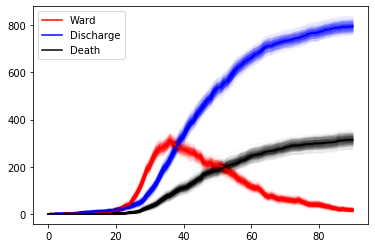

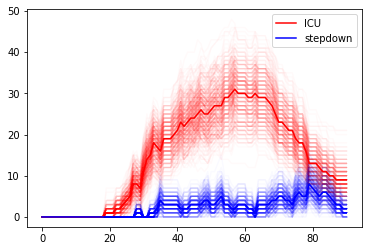

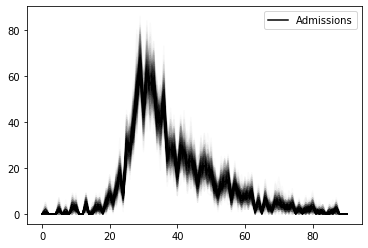

In [14]:
plt.figure()
plt.plot(newcensus[:,0], label = "Ward", c='r', zorder=2)
plt.plot(newcensus[:,3], label = "Discharge", c='b', zorder=2)
plt.plot(newcensus[:,4], label = "Death", c='k', zorder=2)
for b in range(0,nboot):
    plt.plot(newcensusb[b,:,0], c='r', zorder=1, alpha=0.02)
    plt.plot(newcensusb[b,:,3], c='b', zorder=1, alpha=0.02)
    plt.plot(newcensusb[b,:,4], c='k', zorder=1, alpha=0.02)
plt.legend()

plt.figure()
plt.plot(newcensus[:,1], label = "ICU", c='r', zorder=2)
plt.plot(newcensus[:,2], label = "stepdown", c='b', zorder=2)
for b in range(0,nboot):
    plt.plot(newcensusb[b,:,1], c='r', zorder=1, alpha=0.02)
    plt.plot(newcensusb[b,:,2], c='b', zorder=1, alpha=0.02)
plt.legend()

plt.figure()
plt.plot(newcensus[:,5], label = "Admissions", c='k', zorder=2)
for b in range(0,nboot):   
    plt.plot(newcensusb[b,:,5], c='k', zorder=1, alpha=0.02)
plt.legend()

plt.show()